In [1]:
from __future__ import print_function
from __future__ import absolute_import
from infogan.misc.distributions import Uniform, Categorical, Gaussian, MeanBernoulli


import tensorflow as tf
import os
from infogan.misc.datasets import Dataset, MnistDataset
from infogan.models.regularized_gan import RegularizedGAN
from infogan.algos.infogan_trainer import InfoGANTrainer
from infogan.misc.utils import mkdir_p
import dateutil
import dateutil.tz
import datetime

import numpy as np

FFMPEG_BIN = 'ffmpeg'

In [2]:
#%matplotlib inline

/Users/nhdaly/anaconda2/envs/p2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def ParitionData(images):
    num_total_inputs = len(images)

    train_images = images[0:num_total_inputs*6/10]
    cv_images    = images[num_total_inputs*6/10:num_total_inputs*8/10]
    test_images  = images[num_total_inputs*8/10:]
    
    return train_images, cv_images, test_images

In [4]:
class SpeechFramesDataset(object):
    def __init__(self, video_file):
        self.frame_width  = 28
        self.frame_height = 28
        self.frame_depth  =  1 # (number of colors)
        self.image_shape = (self.frame_height, self.frame_width, self.frame_depth)
        self.image_dim = self.frame_height * self.frame_width * self.frame_depth

        all_images = self._load_frames(video_file)
        train_images, cv_images, test_images = ParitionData(all_images)

        self.train = Dataset(np.asarray(train_images))
        self.validation = Dataset(np.asarray(cv_images))
        self.test = Dataset(np.asarray(test_images))
        
    def _open_video_pipe(self, video_file):
        import subprocess as sp
        command = [ FFMPEG_BIN,
            '-i', video_file,
            '-f', 'image2pipe',
            '-pix_fmt', 'gray',
            '-s', '{0}x{1}'.format(self.frame_width, self.frame_height), # -s 1280x960
            '-vcodec', 'rawvideo', '-']
        self.video_pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)

    def _load_frames(self, video_file):
        ''' Import the movie file into a python array of images. '''
        self._open_video_pipe(video_file)
        self.frames = []
        while self.video_pipe:
            # read 1 frame bytes
            raw_image = self.video_pipe.stdout.read(self.image_dim)
            if not raw_image:
                break
            # transform the byte read into a numpy array
            image =  np.fromstring(raw_image, dtype='uint8')
            #image = image.reshape(frame_dim)
            self.frames.append(image)
            # throw away the data in the pipe's buffer.
            self.video_pipe.stdout.flush()
        self.video_pipe = None
        return self.frames
    
    def transform(self, data):
        return data

    def inverse_transform(self, data):
        return data


In [5]:
now = datetime.datetime.now(dateutil.tz.tzlocal())
timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')

root_log_dir = "logs/speech_face"
root_checkpoint_dir = "ckt/speech_face"
batch_size = 128
updates_per_epoch = 100
max_epoch = 50

exp_name = "speech_face_%s" % timestamp

log_dir = os.path.join(root_log_dir, exp_name)
checkpoint_dir = os.path.join(root_checkpoint_dir, exp_name)

mkdir_p(log_dir)
mkdir_p(checkpoint_dir)

dataset = SpeechFramesDataset('../fareeds_take.2015.09.21.speech.full_res.crop.048x054.mov')

# For now, copy the "C.4 Faces" input settings:
# "For this task, we use 5 continuous latent codes and 128 noise variables, so the input to the generator has dimension 133."
latent_spec = [
    (Uniform(128), False),  # Noise
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
    (Uniform(1, fix_std=True), True),
]

model = RegularizedGAN(
    output_dist=MeanBernoulli(dataset.image_dim),
    latent_spec=latent_spec,
    batch_size=batch_size,
    image_shape=dataset.image_shape,
    # TODO: Add a speech_face (or even just face) network_type!!!!!
    network_type="mnist",
)

algo = InfoGANTrainer(
    model=model,
    dataset=dataset,
    batch_size=batch_size,
    exp_name=exp_name,
    log_dir=log_dir,
    checkpoint_dir=checkpoint_dir,
    max_epoch=max_epoch,
    updates_per_epoch=updates_per_epoch,
    snapshot_interval=updates_per_epoch,
    info_reg_coeff=1.0,
    generator_learning_rate=1e-3,
    discriminator_learning_rate=2e-4,
)

algo.train()


KeyboardInterrupt: 

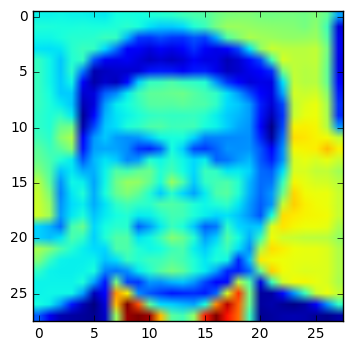

In [16]:
def play_frames_clip(frames):
    ''' frames -- a list/array of np.array images. Plays all frames in the notebook as a clip.'''
    from matplotlib import pyplot as plt
    from IPython import display

    for frame in frames:
        plt.imshow(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)

print(dataset.image_shape)
play_frames_clip([frame.reshape(dataset.image_shape[0], dataset.image_shape[1]) for frame in dataset.train.images[10:20]])